In [1]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from sentence_transformers import SentenceTransformer, util

from typing import TypedDict, Callable, Protocol

import math
import torch
import wikipedia

import matplotlib.pyplot as plt
import networkx as nx

In [2]:
tokenizer = AutoTokenizer.from_pretrained("Babelscape/rebel-large")
model = AutoModelForSeq2SeqLM.from_pretrained("Babelscape/rebel-large")
embeddings = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

In [3]:
class Entity(TypedDict):
    title: str
    url: str
    summary: str


class Relation(TypedDict):
    head: str

    implicit: bool
    type: str | None
    embedding: torch.Tensor | None

    tail: str
    meta: dict


class Source(TypedDict):
    article_title: str
    article_publish_date: str


class ExternalKnowledgeBase(Protocol):
    def get_entity(self, entity_candidate: str) -> Entity | None: ...


EmbeddingsFunction = Callable[[str], torch.Tensor]

SimilarityFunction = Callable[[str, str], float]

In [4]:
default_embeddings_function: EmbeddingsFunction = lambda x: embeddings.encode(
    x, convert_to_tensor=True
)

default_similarity_function: SimilarityFunction = lambda x, y: util.pytorch_cos_sim(
    embeddings.encode(x, convert_to_tensor=True),
    embeddings.encode(y, convert_to_tensor=True),
).item()

In [5]:
class WikipediaKnowledgeBase(ExternalKnowledgeBase):
    def get_entity(self, entity_candidate: str) -> Entity | None:
        try:
            page = wikipedia.page(entity_candidate, auto_suggest=False)
            # return Entity(title=page.title, url=page.url, summary=page.summary)
            return Entity(title=page.title, url=page.url, summary="")
        except:
            return None

In [6]:
default_external_knowledge_bases = [WikipediaKnowledgeBase()]

In [7]:
class KB:
    embeddings_function: EmbeddingsFunction

    similarity_threshold: float
    similarity_function: SimilarityFunction

    external_knowledge_bases: list[ExternalKnowledgeBase]

    entities: dict[str, Entity]
    relations: list[Relation]

    def __init__(
        self,
        external_knowledge_bases: list[
            ExternalKnowledgeBase
        ] = default_external_knowledge_bases,
        embeddings_function: EmbeddingsFunction = default_embeddings_function,
        similarity_function: SimilarityFunction = default_similarity_function,
        similarity_threshold: float = 0.75,
    ):
        self.embeddings_function = embeddings_function

        self.similarity_threshold = similarity_threshold
        self.similarity_function = similarity_function

        self.external_knowledge_bases = external_knowledge_bases

        self.entities = {}
        self.relations = []

    @classmethod
    def from_relations(
        cls,
        relations: list[Relation],
        external_knowledge_bases: list[
            ExternalKnowledgeBase
        ] = default_external_knowledge_bases,
        embeddings_function: EmbeddingsFunction = default_embeddings_function,
        similarity_function: SimilarityFunction = default_similarity_function,
        similarity_threshold: float = 0.75,
    ):
        kb = cls(
            external_knowledge_bases=external_knowledge_bases,
            embeddings_function=embeddings_function,
            similarity_function=similarity_function,
            similarity_threshold=similarity_threshold,
        )
        for r in relations:
            kb.add_relation(r, "", "")
        return kb

    def are_relations_equal(self, r1: Relation, r2: Relation) -> bool:
        if r1["implicit"] != r2["implicit"]:
            return False

        match = all(
            r1.get(attr, None) == r2.get(attr, None)
            for attr in ["head", "type", "tail"]
        )

        if r1["implicit"]:
            return torch.allclose(r1["embedding"], r2["embedding"]) and match

        return match

    def has_similar_relation(self, relation: Relation, threshold=0.8) -> bool:
        for candidate_relation in self.relations:
            if (
                self.similarity_function(relation["head"], candidate_relation["head"])
                < threshold
            ):
                continue

            if (
                self.similarity_function(relation["tail"], candidate_relation["tail"])
                < threshold
            ):
                continue

            if candidate_relation["implicit"]:
                similarity = util.pytorch_cos_sim(
                    embeddings.encode(relation["type"], convert_to_tensor=True),
                    candidate_relation["embedding"],
                ).item()

                if similarity < threshold:
                    continue
            elif (
                self.similarity_function(relation["type"], candidate_relation["type"])
                < threshold
            ):
                continue

            return True

        return False

    def exists_relation(self, r1: Relation) -> bool:
        return any(self.are_relations_equal(r1, r2) for r2 in self.relations)

    def get_entity_from_kb(self, candidate_entity: str) -> Entity | None:
        if len(self.entities) == 0:
            return None

        entity, similarity = max(
            (
                (e, self.similarity_function(candidate_entity, e["title"]))
                for e in self.entities.values()
            ),
            key=lambda x: x[1],
        )

        if similarity < self.similarity_threshold:
            return None

        return entity

    def get_empty_entity(self, candidate_entity: str) -> Entity:
        return Entity(title=candidate_entity, url="", summary="")

    def add_entity(self, e: Entity) -> None:
        # self.entities[e["title"]] = {k: v for k, v in e.items() if k != "title"}
        self.entities[e["title"]] = e

    def add_relation(self, r: Relation, article_title: str, article_publish_date: str):
        candidate_entities = [r["head"], r["tail"]]

        entities = [self.get_entity_from_kb(ent) for ent in candidate_entities]

        for ekb in self.external_knowledge_bases:
            entities = [
                ekb.get_entity(c) if e is None else e
                for e, c in zip(entities, candidate_entities)
            ]

        entities = [
            self.get_empty_entity(c) if e is None else e
            for e, c in zip(entities, candidate_entities)
        ]

        # if one entity does not exist, stop
        if any(ent is None for ent in entities):
            return

        # manage new entities
        for e in entities:
            self.add_entity(e)

        # rename relation entities with their wikipedia titles
        r["head"] = entities[0]["title"]
        r["tail"] = entities[1]["title"]

        # manage new relation
        if not self.exists_relation(r):
            self.relations.append(r)

    def get_out_edges(self, entity: Entity) -> list[Relation]:
        return [r for r in self.relations if r["head"] == entity["title"]]

    def get_in_edges(self, entity: Entity) -> list[Relation]:
        return [r for r in self.relations if r["tail"] == entity["title"]]

    def get_out_degree(self, entity: Entity) -> int:
        return len(self.get_out_edges(entity))

    def merge_entities(self, e1: Entity, e2: Entity) -> Entity:
        if e1["title"] not in self.entities or e2["title"] not in self.entities:
            return

        # into e1
        for r in self.get_in_edges(e2):
            r["tail"] = e1["title"]

        for r in self.get_out_edges(e2):
            r["head"] = e1["title"]

        # remove e2
        del self.entities[e2["title"]]

    def refine_identity_links(self):
        entities = list(self.entities.values())
        embeddings = [self.embeddings_function(e["title"]) for e in entities]

        for i, e1 in enumerate(entities):
            for j, e2 in enumerate(entities):
                if i == j:
                    continue

                similarity = util.pytorch_cos_sim(embeddings[i], embeddings[j]).item()

                if similarity > 0.9:
                    self.merge_entities(e1, e2)

    def refine_implicit_links(self):
        if len(self.entities) < 2:
            return

        entities = list(self.entities.values())

        while len(entities) > 1:
            entities.sort(key=lambda e: self.get_out_degree(e))

            lowest_degree = entities.pop(0)

            entities.sort(
                key=lambda e: self.similarity_function(
                    lowest_degree["title"], e["title"]
                ),
                reverse=True,
            )
            most_similar = entities.pop(0)

            lowest_embedding = self.embeddings_function(lowest_degree["title"])
            median_embedding = self.embeddings_function(most_similar["title"])

            relation_embedding = median_embedding - lowest_embedding
            relation = Relation(
                head=lowest_degree["title"],
                implicit=True,
                type=None,
                embedding=relation_embedding,
                tail=most_similar["title"],
                meta={},
            )

            if not self.has_similar_relation(relation):
                self.add_relation(relation, "", "")
                break

    def refine(self):
        self.refine_identity_links()
        self.refine_implicit_links()

    def print(self):
        print("Entities:")
        for e in self.entities.items():
            print(f"  {e}")
        print("Relations:")
        for r in self.relations:
            print(f"  {r}")

    def plot(self, ax=None, seed=42):
        if ax is None:
            ax = plt.gca()

        # create network
        G = nx.DiGraph()

        # add nodes
        for e in self.entities:
            G.add_node(e, shape="circle")

        # add edges
        for r in self.relations:
            title = "<implicit>" if r["implicit"] else r["type"]
            label = title

            G.add_edge(r["head"], r["tail"], title=title, label=label)

        node_labels = {e: e for e in G.nodes()}
        edge_labels = {
            tuple(edge): attrs["label"] for *edge, attrs in G.edges(data=True)
        }

        explicit_edges = [
            (h, t) for h, t in G.edges() if G.edges[h, t]["title"] != "<implicit>"
        ]
        implicit_edges = [
            (h, t) for h, t in G.edges() if G.edges[h, t]["title"] == "<implicit>"
        ]

        # plot network
        pos = nx.spring_layout(G, k=0.2, seed=seed)
        nx.draw_networkx_nodes(G, pos=pos, ax=ax, node_color="lightblue")
        nx.draw_networkx_labels(G, pos=pos, labels=node_labels, ax=ax)
        nx.draw_networkx_edges(G, pos=pos, edgelist=explicit_edges, ax=ax)
        nx.draw_networkx_edges(
            G, pos=pos, edgelist=implicit_edges, style="dashed", ax=ax
        )

        nx.draw_networkx_edge_labels(G, edge_labels=edge_labels, pos=pos, ax=ax)

In [8]:
def extract_relations_from_model_output(text):
    relations = []
    relation, subject, relation, object_ = "", "", "", ""
    text = text.strip()
    current = "x"
    text_replaced = text.replace("<s>", "").replace("<pad>", "").replace("</s>", "")
    for token in text_replaced.split():
        if token == "<triplet>":
            current = "t"
            if relation != "":
                relations.append(
                    Relation(
                        head=subject.strip(),
                        implicit=False,
                        type=relation.strip(),
                        tail=object_.strip(),
                        meta={},
                    )
                )
                relation = ""
            subject = ""
        elif token == "<subj>":
            current = "s"
            if relation != "":
                relations.append(
                    Relation(
                        head=subject.strip(),
                        implicit=False,
                        type=relation.strip(),
                        tail=object_.strip(),
                        meta={},
                    )
                )
            object_ = ""
        elif token == "<obj>":
            current = "o"
            relation = ""
        else:
            if current == "t":
                subject += " " + token
            elif current == "s":
                object_ += " " + token
            elif current == "o":
                relation += " " + token

    if subject != "" and relation != "" and object_ != "":
        relations.append(
            Relation(
                head=subject.strip(),
                implicit=False,
                type=relation.strip(),
                tail=object_.strip(),
                meta={},
            )
        )

    return relations

In [9]:
def get_relations(
    text,
    source,
    span_length=128,
    # article_title=None,
    # article_publish_date=None,
    verbose=False,
):
    # tokenize whole text
    inputs = tokenizer([text], return_tensors="pt")

    # compute span boundaries
    num_tokens = len(inputs["input_ids"][0])
    if verbose:
        print(f"Input has {num_tokens} tokens")
    num_spans = math.ceil(num_tokens / span_length)
    if verbose:
        print(f"Input has {num_spans} spans")
    overlap = math.ceil((num_spans * span_length - num_tokens) / max(num_spans - 1, 1))
    spans_boundaries = []
    start = 0
    for i in range(num_spans):
        spans_boundaries.append(
            [start + span_length * i, start + span_length * (i + 1)]
        )
        start -= overlap
    if verbose:
        print(f"Span boundaries are {spans_boundaries}")

    # transform input with spans
    tensor_ids = [
        inputs["input_ids"][0][boundary[0] : boundary[1]]
        for boundary in spans_boundaries
    ]
    tensor_masks = [
        inputs["attention_mask"][0][boundary[0] : boundary[1]]
        for boundary in spans_boundaries
    ]
    inputs = {
        "input_ids": torch.stack(tensor_ids),
        "attention_mask": torch.stack(tensor_masks),
    }

    # generate relations
    num_return_sequences = 3
    gen_kwargs = {
        "max_length": 256,
        "length_penalty": 0,
        "num_beams": 3,
        "num_return_sequences": num_return_sequences,
    }
    generated_tokens = model.generate(
        **inputs,
        **gen_kwargs,
    )

    # decode relations
    decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=False)

    if verbose:
        print(f"{decoded_preds=}")

    all_relations = []
    i = 0
    for sentence_pred in decoded_preds:
        current_span_index = i // num_return_sequences
        relations = extract_relations_from_model_output(sentence_pred)

        if verbose:
            print(f"{relations=}")

        for relation in relations:
            relation["meta"] = {
                source: {"spans": [spans_boundaries[current_span_index]]}
            }
        i += 1

        all_relations += relations

    return all_relations


def from_text_to_kb(
    text,
    article_url,
    article_title=None,
    article_publish_date=None,
    verbose=False,
):
    kb = KB()
    for relation in get_relations(
        text,
        article_url,
        verbose=verbose,
    ):
        kb.add_relation(relation, article_title, article_publish_date)

    return kb

In [10]:
text = "Kobe Bean Bryant (August 23, 1978 – January 26, 2020) was an American professional basketball player. A shooting guard, he spent his entire 20-year career with the Los Angeles Lakers in the National Basketball Association (NBA). Widely regarded as one of the greatest basketball players of all time, Bryant won five NBA championships, was an 18-time All-Star, a 15-time member of the All-NBA Team, a 12-time member of the All-Defensive Team, the 2008 NBA Most Valuable Player (MVP), and a two-time NBA Finals MVP. Bryant also led the NBA in scoring twice, and ranks fourth in league all-time regular season and postseason scoring. He was posthumously voted into the Naismith Memorial Basketball Hall of Fame in 2020 and named to the NBA 75th Anniversary Team in 2021."

In [13]:
kb = from_text_to_kb(text, "")

/home/alen/anaconda3/lib/python3.11/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /home/alen/anaconda3/lib/python3.11/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


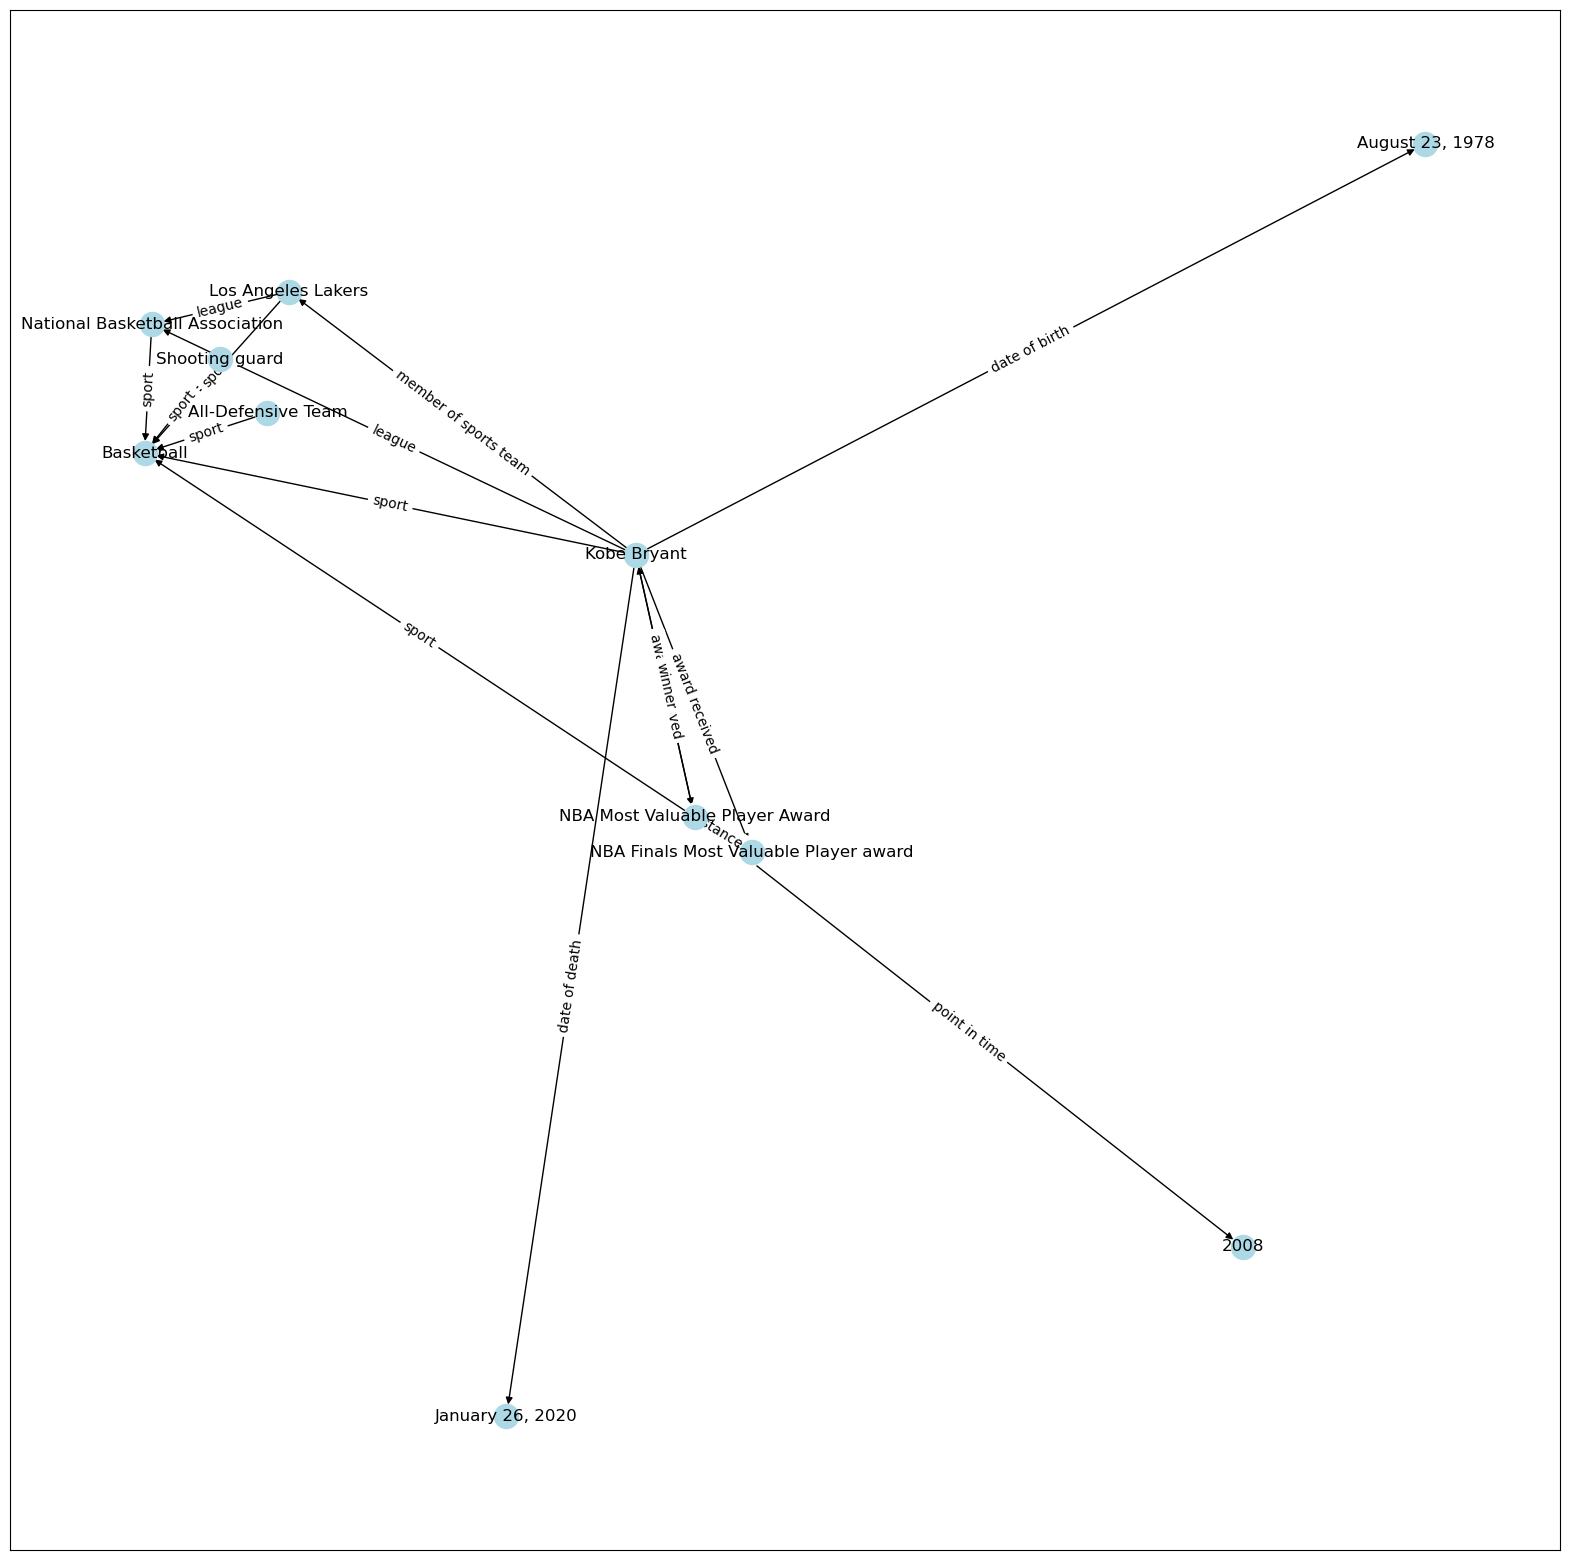

In [14]:
plt.figure(figsize=(20, 20))
kb.plot()
plt.show()

In [15]:
target_kb = KB.from_relations(
    get_relations(
        "Kobe is a basketball player. Kobe is an Most Valuable Player.",
        "",
    ),
    similarity_threshold=0.9,
)

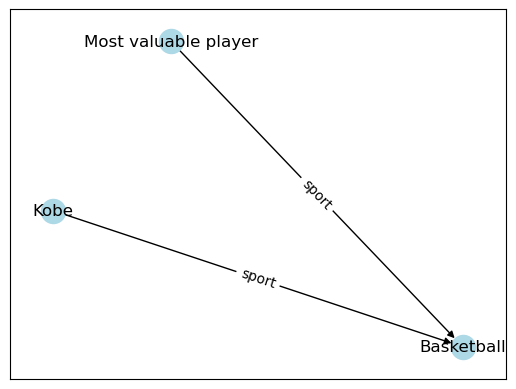

In [16]:
target_kb.plot()
plt.show()

In [17]:
import itertools
from typing import Iterable


def rank_candidate_vertices(
    kb: KB, entity: Entity, threshold=0.8
) -> Iterable[tuple[Entity, float]]:
    similarities = [
        (e, kb.similarity_function(entity["title"], e["title"]))
        for e in kb.entities.values()
    ]

    return sorted(
        ((e, s) for e, s in similarities if s >= threshold),
        key=lambda x: x[1],
        reverse=True,
    )

In [18]:
def get_candidate_vertices(
    kb: KB, entities: list[Entity], threshold=0.8
) -> Iterable[list[tuple[Entity, float]]]:
    """
    Example
    Input:
        entities=[a, b, c]

    Output:
        [
            [1st entity similar to a, 1st entity similar to b, 1st entity similar to c],
            [1st entity similar to a, 1st entity similar to b, 2nd entity similar to c],
            ...
            [2nd entity similar to a, 2nd entity similar to b, 2nd entity similar to c]
        ]
    """

    candidates = [
        rank_candidate_vertices(kb, entity, threshold=threshold) for entity in entities
    ]

    return itertools.product(*candidates)

In [29]:
def match(kb: KB, query_kb: KB, verbose=False, threshold=0.8):
    entities = list(query_kb.entities.values())

    if verbose:
        kb_titles = [entity["title"] for entity in kb.entities.values()]
        query_titles = [entity["title"] for entity in entities]
        print(f"Matching entities {query_titles} in {kb_titles}")

    for i, candidate_vertices in enumerate(
        get_candidate_vertices(kb, entities, threshold=threshold)
    ):
        if verbose:
            print(f"{i=}, {candidate_vertices=}")

        mapping = {
            query_entity["title"]: entity["title"]
            for query_entity, (entity, _) in zip(entities, candidate_vertices)
        }

        candidate_relations = [
            {
                "head": mapping[relation["head"]],
                "type": relation["type"],
                "tail": mapping[relation["tail"]],
            }
            for relation in query_kb.relations
        ]

        if all(
            kb.has_similar_relation(candidate_relation, threshold=threshold)
            for candidate_relation in candidate_relations
        ):
            return mapping

    return None

In [30]:
def search(kb, query_kb, max_iterations=10, threshold=0.8, verbose=False):
    i = 0

    while i < max_iterations:
        if verbose:
            print(f"Iteration {i}")

        mapping = match(kb, query_kb, threshold=threshold, verbose=verbose)

        if mapping is not None:
            return mapping

        kb.refine()
        i += 1

    return None

In [31]:
m = search(kb, target_kb, verbose=True, threshold=0.5)

print(m)

Iteration 0
Matching entities ['Most valuable player', 'Basketball', 'Kobe'] in ['Kobe Bryant', 'August 23, 1978', 'January 26, 2020', 'Basketball', 'Los Angeles Lakers', 'National Basketball Association', 'NBA Most Valuable Player Award', 'Shooting guard', 'All-Defensive Team', '2008']
i=0, candidate_vertices=(({'title': 'NBA Most Valuable Player Award', 'url': 'https://en.wikipedia.org/wiki/NBA_Most_Valuable_Player_Award', 'summary': ''}, 0.7662790417671204), ({'title': 'Basketball', 'url': 'https://en.wikipedia.org/wiki/Basketball', 'summary': ''}, 1.0), ({'title': 'Kobe Bryant', 'url': 'https://en.wikipedia.org/wiki/Kobe_Bryant', 'summary': ''}, 0.9160639047622681))
{'Most valuable player': 'NBA Most Valuable Player Award', 'Basketball': 'Basketball', 'Kobe': 'Kobe Bryant'}


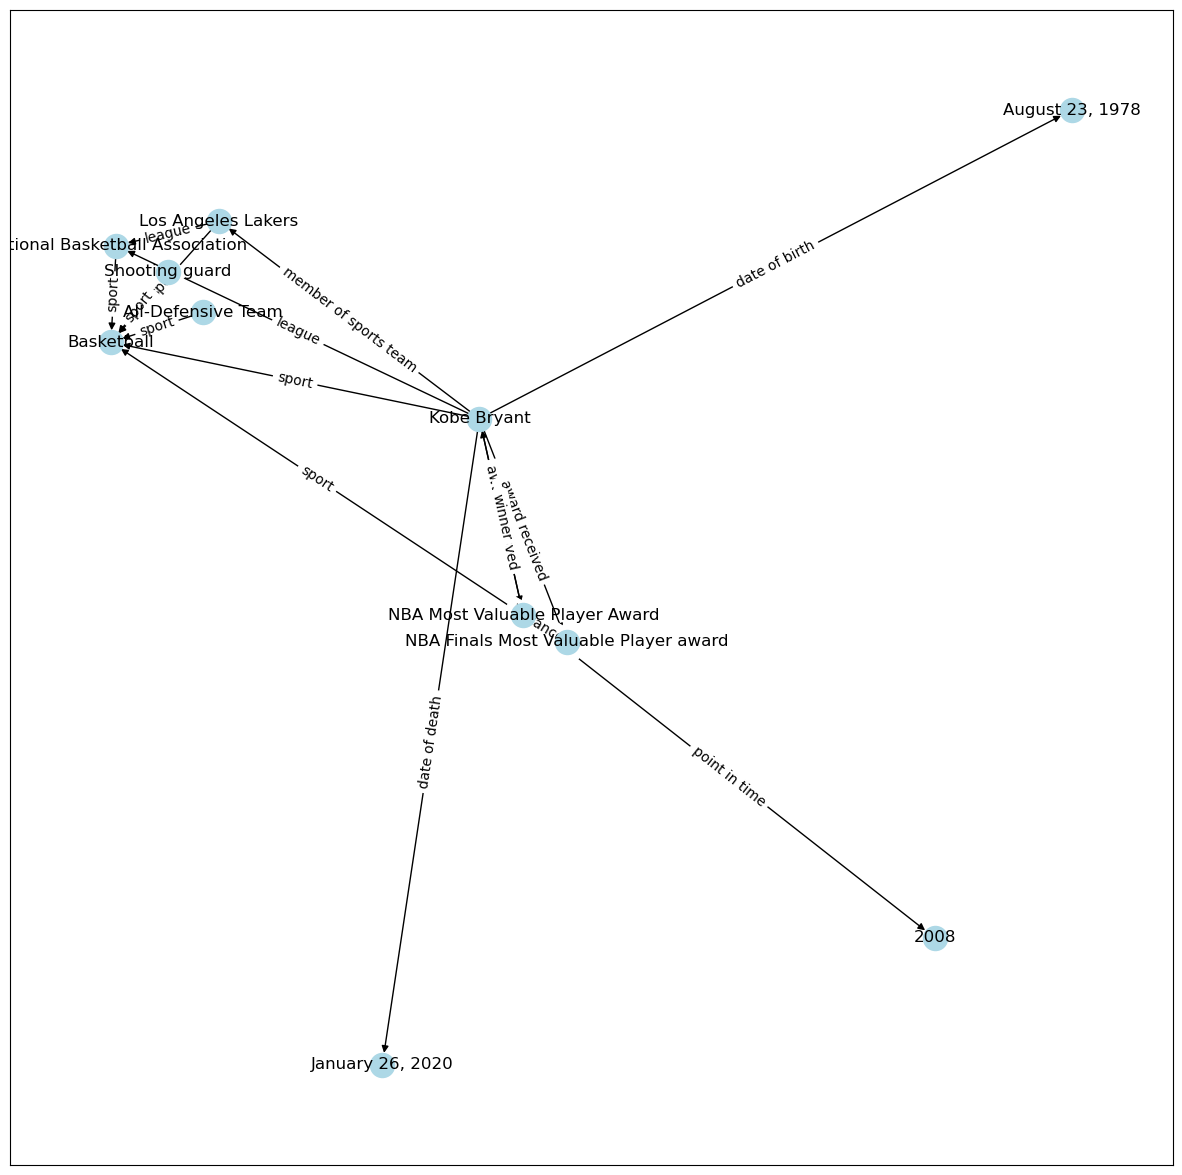

In [21]:
plt.figure(figsize=(15, 15))
kb.plot()
plt.show()

In [27]:
kb.refine()

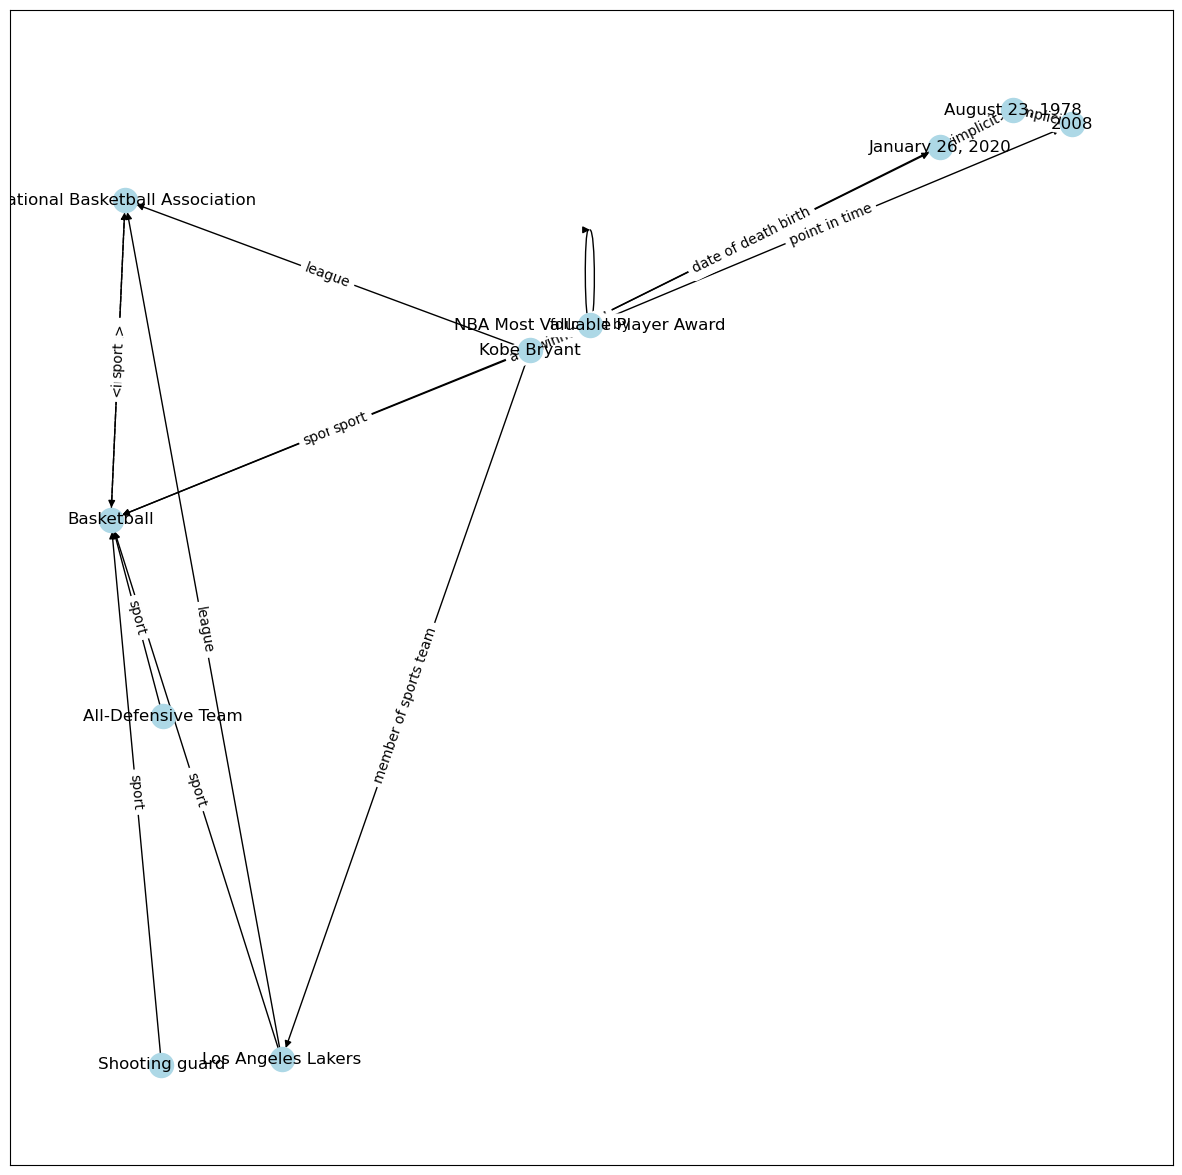

In [28]:
plt.figure(figsize=(15, 15))
kb.plot(seed=119)
plt.show()